# <center> Lab 02 Part2: Classification, Logistic Regression<br> <small>Réda DEHAK<br> 17 Mai 2021</small> </center>

The goal of this lab is:

    - Test the logistic regression on classification problems.

## Part 2: Logistic Regression 
### Import Data

We will use the Wine dataset from UCI. These data are the results of a chemical analysis of wines grown in the same region in Italy but derived from three different cultivars. The analysis determined the quantities of thirteen constituents found in each of the three types of wines.

# Loading and Plotting Data
 
First, we will use only two features from the data set: alcohol and ash (We can plot the solution in 2D space). The labels are supplied as an array of data with values from 1 to 3, but at first, we want a simple binary regression problem with a yes or no answer.  

We filter the data set, reducing it to only include wines with labels 1 or 2.  

In [1]:
%pylab
%matplotlib inline
import pickle
import matplotlib.pyplot as plt
import numpy as np

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
from sklearn.preprocessing import label_binarize

data = pd.read_csv('data3.txt')

reduced = data[data['class'] <= 2]
X = reduced[['alcohol', 'ash']].to_numpy()
y = label_binarize(reduced['class'].to_numpy(), classes=[1, 2])[:,0]

In [3]:
# split data into train and validation set
from sklearn.model_selection import train_test_split

#Fix random_state to have the same split for each run 
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=42)
print('train:', len(Xtrain), 'test:', len(Xtest))

train: 97 test: 33


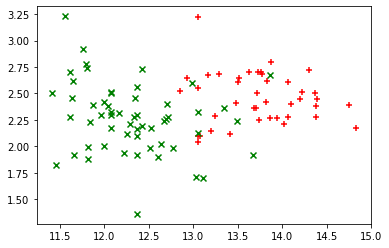

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

MARKERS = ['+', 'x', '.']
COLORS = ['red', 'green', 'blue']

def plot_points(xy, labels):
    
    for i, label in enumerate(set(labels)):
        points = np.array([xy[j,:] for j in range(len(xy)) if labels[j] == label])
        marker = MARKERS[i % len(MARKERS)]
        color = COLORS[i % len(COLORS)]
        plt.scatter(points[:,0], points[:,1], marker=marker, color=color)

plot_points(Xtrain, ytrain)

We can see that we can plot line that could divide the two colored points with a small amount of error.

# Logistic Regression

To implement logistic regression, we need to define the cost function $J(\theta)$, and compute the partial derivatives of $J(\theta)$. As we have seen previously:

$$
J(\theta) =-\frac{1}{N}\sum_{i=1}^{N}y^{i}\log(f_\theta(x^{i}))+(1-y^{i})\log(1-f_\theta(x^{i}))
$$

where $f_\theta(x)$ is the logistic function

$$
f_\theta(x) = \frac{1}{1 + e^{-\theta^Tx}}
$$

- Compute the partiel derivatives of $J(\theta)$ and write the two functions:
    - cost(theta, X, y) which compute the value of $J(\theta)$
    - gradient(theta, X, y) which compute the value of the gradient of $J(\theta)$

In [5]:
def sigmoid(theta, X):
    return 1 / (1 + np.exp(-theta @ X.T))

def cost(theta, X, y):
    N = X.shape[0]
    return -(1/N) * np.sum(y * np.log(sigmoid(theta, X)) + (1 - y) * np.log(1 - sigmoid(theta, X)))

def gradient(theta, X, y):
    return X.T @ (sigmoid(theta, X) - y)  

- Using the function scipy.optimize.fmin_tnc which performs a gradient descent algorithm, write a function Train(x, y) which compute $\theta$ that minimize $J(\theta)$

In [6]:
from scipy.optimize import fmin_tnc

def train(X, y):
    X = np.insert(X, 0, np.ones(len(X)), axis=1)
    theta = np.zeros(X.shape[1])
    result = fmin_tnc(func=cost, x0=theta, fprime=gradient, args=(X, y))
    
    return result[0]

- compute the value of the best $\theta$

In [7]:
theta = train(Xtrain,ytrain)

- Plot the boundary and checks that it is linear?

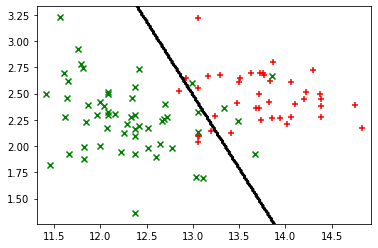

In [8]:
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap

def predict(theta, X):
    X = np.insert(X, 0, np.ones(len(X)), axis=1)
    return (sigmoid(theta, X) >= 0.5).astype(int)
    
def plot_boundary(X, pred):
    
    x_min, x_max = X[:,0].min() - .1, X[:,0].max() + .1
    y_min, y_max = X[:,1].min() - .1, X[:,1].max() + .1
    
    xs, ys = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200)
    )

    xys = np.column_stack([xs.ravel(), ys.ravel()])
    zs = pred(xys).reshape(xs.shape)
    plt.contour(xs, ys, zs, colors='black')
  
plot_boundary(Xtrain, lambda x: predict(theta, x))
plot_points(Xtrain, ytrain)

## - Using sklearn.metrics, compute the confusion matrix, the accuracy, the precision and the recall of this classifier

In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

predictions = predict(theta, X)
print('accuracy:', accuracy_score(y, predictions))
print('precision:', precision_score(y, predictions,average='macro'))
print('recall:', recall_score(y, predictions,average='macro'))

accuracy: 0.9230769230769231
precision: 0.9224158510384339
recall: 0.9224158510384339


- How can we obtain a quadratic boundary? check it and plot the boundary?

[195.35818843   1.14145169   0.78266219  -2.1733293  -29.04431825
  21.92241095]


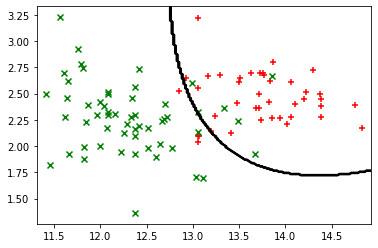

In [10]:
from sklearn.preprocessing import PolynomialFeatures

def transform(x):
    #return PolynomialFeatures(2).fit_transform(x)
    return np.vstack((x[:, 0] ** 2, x[:, 1] ** 2, x[:, 0] * x[:, 1], x[:, 0], x[:, 1])).T


W = train(transform(Xtrain), ytrain)
print(W)
plot_points(Xtrain, ytrain)
plot_boundary(Xtrain, lambda x: predict(W, transform(x)))

- Compute the confusion matrix, the accuracy, the precision and the recall of this classifier

In [11]:
predictions_bis = predict(W, transform(X))
print('confusion matrix:', confusion_matrix(y, predictions_bis))
print('accuracy:', accuracy_score(y, predictions_bis))
print('precision:', precision_score(y, predictions_bis))
print('recall:', recall_score(y, predictions_bis))

confusion matrix: [[55  4]
 [ 6 65]]
accuracy: 0.9230769230769231
precision: 0.9420289855072463
recall: 0.9154929577464789


# Multinomial Logistic Regression

The next step is something more interesting: we use a similar set of two features from the data set (this time alcohol and flavanoids), but with all three labels instead of two.

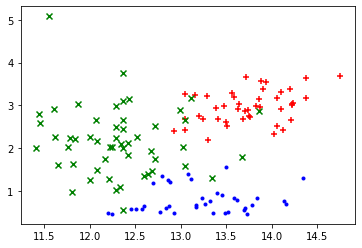

In [12]:
X = data[['alcohol', 'flavanoids']].to_numpy()
y = data[['class']].to_numpy()
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25)
ytrain = label_binarize(ytrain, classes=[1, 2, 3])
plot_points(Xtrain, ytrain.argmax(axis=1))

The plotted data points again suggest some obvious linear boundaries between the three classes.

We can solve this problem as three one-vs-all problems, and re-use all the previous code. In this part, we will try another solution inspired from softmax function known as softmax regression (See C.Bishop, "Pattern Recognition and Machine Learning", 2006, Springer).

$$
SoftMax_\Theta(x, k) = \frac{e^{\theta_k^Tx}}{\sum\limits_{c=1}^K e^{\theta_c^Tx}}
$$

The cost function is defined as follows:

$$
J(\Theta) =-\frac{1}{N}\sum_{i=1}^{N}\sum_{k=1}^3\left[y_k^{i}\log\left(SoftMax_\Theta\left(x^{i}, k\right)\right)\right]
$$

- Propose a solution using the SoftMax function and test it with linear and quadratic separator? 

In [15]:
def softmax(w, x):
    w = w.reshape((x.shape[1], -1))
    K = w.shape[1]
    N = x.shape[0]
    y = np.zeros((N, K))
    for k in range(K):
        y[:, k] = np.exp(x.dot(w[:, k]))
    s = np.sum(y, axis = 1)
    y = np.diag(1./s) @ y
    return y

def cost(w, x, y):
    w = w.reshape((x.shape[1], -1))
    yhat = softmax(w, x)
    K = w.shape[1]
    s = 0
    for k in range(K):
        s += np.sum(y[:, k] * np.log(yhat[:, k])) 
    return -s / len(y) 

def grad(w, x, y):
    error = softmax(w, x) - y
    return x.T @ error / x.shape[0] 

def train(X, y):
    X = np.insert(X, 0, np.ones(len(X)), axis=1)
    theta = np.zeros((X.shape[1], y.shape[1]))
    result = fmin_tnc(func=cost, x0=theta, fprime=grad, disp=5, args=(X, y))
    
    return result[0].reshape((X.shape[1], -1))

W3 = train((Xtrain), ytrain)

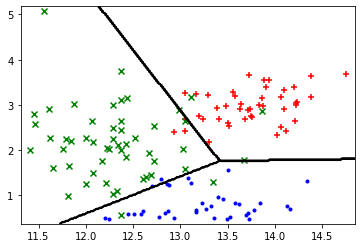

In [16]:
#Linear Separator

def predict_multi(w, x):
    x = np.insert(x, 0, np.ones(len(x)), axis=1)
    preds = softmax(w, x)
    return preds.argmax(axis=1)

plot_points(Xtrain, ytrain.argmax(axis=1))
plot_boundary(Xtrain, lambda x: predict_multi(W3, x))

[[ -5.5483719   12.87012274 -29.78341567]
 [ -5.5483719   12.87012274 -29.78341567]
 [  2.25063729  -0.59045069   0.78605642]
 [ -8.67267168   2.38555991  72.53167717]
 [ -0.28087834  -0.14232599   0.33334021]
 [  1.86093819  -0.25491854  -6.27537828]
 [ -0.92063144   1.93726169   1.2260073 ]]


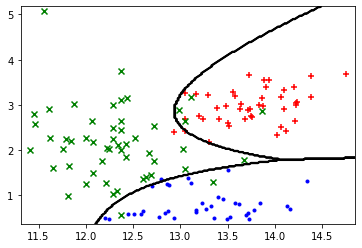

In [17]:
def transform(x):
    return PolynomialFeatures(2).fit_transform(x)
# Quadratic Separator
W4 = train(transform(Xtrain), ytrain)
print(W4)

plot_points(Xtrain, ytrain.argmax(axis=1))
plot_boundary(Xtrain, lambda x:predict_multi(W4, transform(x)))

- Compute the confusion matrix, the accuracy, the precision and the recall of these classifiers

In [18]:
print(Xtest.shape)
predictions = predict_multi(W3, Xtest) + 1
print('accuracy:', accuracy_score(ytest, predictions))
print('precision:', precision_score(ytest, predictions, average='macro'))
print('recall:', recall_score(ytest, predictions, average='macro'))

(45, 2)
accuracy: 0.9111111111111111
precision: 0.9285714285714285
recall: 0.9077086656034025
